In [1]:
# Path to ffmpeg
ffmpeg_path = '../bin/ffmpeg/ffmpeg'

%matplotlib inline
import sys
import os.path
# Make sure ffmpeg is on the path so sk-video can find it
sys.path.append(os.path.dirname(ffmpeg_path))
import skvideo.io
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pafy
import soundfile as sf
import subprocess as sp
from IPython.display import Video

/home/jsondotload/projects/research/marl/sonyc/audiosetdl/bin/miniconda/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [2]:
# Set output settings
audio_codec = 'flac'
audio_container = 'flac'
video_codec = 'h264'
video_container = 'mp4'

### We can load the AudioSet training set and grab a video to download:

In [3]:
# Load the AudioSet training set
with open('../data/unbalanced_train_segments.csv') as f:
    lines = f.readlines()

dl_list = [line.strip().split(',')[:3] for line in lines[3:]]

In [4]:
# Select a YouTube video from the training set
ytid, ts_start, ts_end = dl_list[0]
ts_start, ts_end = float(ts_start), float(ts_end)
duration = ts_end - ts_start

print("YouTube ID: " + ytid)
print("Trim Window: ({}, {})".format(ts_start, ts_end))

YouTube ID: ---1_cCGK4M
Trim Window: (0.0, 10.0)


### After getting the YouTube ID and trim window for the video we want, we can use `pafy` to get the download URL to the best quality video and audio:

In [16]:
# Get the URL to the video page
video_page_url = 'https://www.youtube.com/watch?v={}'.format(ytid)

# Get the direct URLs to the videos with best audio and with best video (with audio)
video = pafy.new(video_page_url)

best_video = video.getbestvideo()
best_video_url = best_video.url
print("Video URL: " + best_video_url)

best_audio = video.getbestaudio()
best_audio_url = best_audio.url
print("Audio URL: " + best_audio_url)

Video URL: https://r6---sn-a8au-xfge.googlevideo.com/videoplayback?itag=248&mime=video%2Fwebm&mn=sn-a8au-xfge&expire=1507017564&pl=17&lmt=1506921523769325&mv=m&id=o-AFpl17rZbuzZVtsMJj1xtNgTRdyoIFk6CsLx-KS227R1&source=youtube&clen=8272975&mm=31&aitags=133%2C134%2C135%2C136%2C137%2C160%2C242%2C243%2C244%2C247%2C248%2C278&key=yt6&ip=216.165.95.181&keepalive=yes&signature=CE7DE3E959A71D024D4997912FFF84FAD8092491.22BC14F6B574581B877D4CAFEA7171E81999784C&mt=1506995864&initcwndbps=4671250&gir=yes&ipbits=0&ms=au&requiressl=yes&sparams=aitags%2Cclen%2Cdur%2Cei%2Cgir%2Cid%2Cinitcwndbps%2Cip%2Cipbits%2Citag%2Ckeepalive%2Clmt%2Cmime%2Cmm%2Cmn%2Cms%2Cmv%2Cpl%2Crequiressl%2Csource%2Cexpire&dur=23.524&ei=_O7SWZGMEYaX8gTZ4Y2YDQ&ratebypass=yes
Audio URL: https://r6---sn-a8au-xfge.googlevideo.com/videoplayback?itag=251&mime=audio%2Fwebm&expire=1507017564&pl=17&lmt=1506921231297517&mv=m&id=o-AFpl17rZbuzZVtsMJj1xtNgTRdyoIFk6CsLx-KS227R1&source=youtube&clen=269796&mm=31&mn=sn-a8au-xfge&key=yt6&ip=216.165.9

In [8]:
# Get output video and audio filepaths
basename_fmt = '{}_{}_{}'.format(ytid, int(ts_start*1000), int(ts_end*1000))
video_filepath = os.path.join('.', basename_fmt + '.' + video_container)
audio_filepath = os.path.join('.', basename_fmt + '.' + audio_codec)

### We can then use `ffmpeg` to download and transcode to the format desired:

In [10]:
# Download the video
video_dl_args = [ffmpeg_path, '-n',
    '-ss', str(ts_start),   # The beginning of the trim window
    '-i', best_video_url,   # Specify the input video URL
    '-t', str(duration),    # Specify the duration of the output
    '-f', video_container,  # Specify the format (container) of the video
    '-framerate', '30',     # Specify the framerate
    '-vcodec', 'h264',      # Specify the output encoding
    video_filepath]

proc = sp.Popen(video_dl_args, stdout=sp.PIPE, stderr=sp.PIPE)
stdout, stderr = proc.communicate()
if proc.returncode != 0:
    print(stderr)
else:
    print("Downloaded video to " + video_filepath)

Downloaded video to ./---1_cCGK4M_0_10000.mp4


In [20]:
# Download the audio
audio_dl_args = [ffmpeg_path, '-n',
    '-ss', str(ts_start),    # The beginning of the trim window
    '-i', best_audio_url,    # Specify the input video URL
    '-t', str(duration),     # Specify the duration of the output
    '-vn',                   # Suppress the video stream
    '-ac', '2',              # Set the number of channels
    '-sample_fmt', 's16',    # Specify the bit depth
    '-acodec', audio_codec,  # Specify the output encoding
    '-ar', '44100',          # Specify the audio sample rate
    audio_filepath]

proc = sp.Popen(audio_dl_args, stdout=sp.PIPE, stderr=sp.PIPE)
stdout, stderr = proc.communicate()
if proc.returncode != 0:
    print(stderr)
else:
    print("Downloaded audio to " + audio_filepath)

Downloaded audio to ./---1_cCGK4M_0_10000.flac


In [ ]:
# Download the video (higher quality) separately and merge with the audio
solo_video_filepath = './solo_' + video_filepath[2:]
video_dl_args = [ffmpeg_path, '-n',
    '-ss', str(ts_start),   # The beginning of the trim window
    '-i', best_video_url,   # Specify the input video URL
    '-t', str(duration),    # Specify the duration of the output
    '-f', 'mp4',            # Specify the format (container) of the video
    '-framerate', '30',     # Specify the framerate
    '-vcodec', 'h264',      # Specify the output encoding
    '-crf', '0',            # Lossless
    '-preset', 'medium',    # Use the medium compression strategy, which
                            # offers a balance between speed and compression rate
    solo_video_filepath]

proc = sp.Popen(video_dl_args, stdout=sp.PIPE, stderr=sp.PIPE)
stdout, stderr = proc.communicate()
if proc.returncode != 0:
    print(stderr)
else:
    print("Downloaded video to " + video_filepath)
    
merge_video_filepath = './merge_' + video_filepath[2:]
merge_video_dl_args = [ffmpeg_path, '-n',
    '-i', video_filepath,      # Specify the high quality video path
    '-i', audio_filepath,      # specify the high quality audio path
    '-f', 'mp4',               # Specify the format (container) of the video
    '-framerate', '30',        # Specify the video framerate
    '-vcodec', 'h264',         # Specify the output video encoding
    '-acodec', 'aac',          # Specify the output audio encoding
    '-ac', '2',                # Set the number of channels
    '-ar', '44100',            # Specify the audio sample rate
    '-strict', 'experimental', # Needed for merging streams
    merge_video_filepath]

proc = sp.Popen(merge_video_dl_args, stdout=sp.PIPE, stderr=sp.PIPE)
stdout, stderr = proc.communicate()
if proc.returncode != 0:
    print(stderr)
else:
    print("Merged video at " + merge_video_filepath)

### After using ffmpeg to download and transcode to `.mp4` (video) and `.flac` (audio). We can read them back as below.

In [ ]:
# To plot one frame
cap = cv2.VideoCapture('./video.mp4')
ret, frame = cap.read()
plt.imshow(frame)

cap.release()
cv2.destroyAllWindows()

(-0.5, 1279.5, 719.5, -0.5)

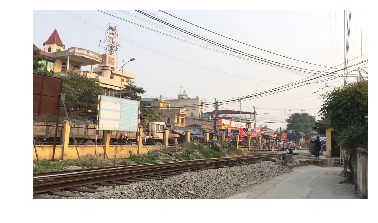

In [9]:
# Plot one frame, alternatively using skvideo
videodata = skvideo.io.vread(video_filepath)
plt.imshow(videodata[0])
plt.axis('off')

In [ ]:
# To play back the video
cap = cv2.VideoCapture(video_filepath)

while(cap.isOpened()):
    ret, frame = cap.read()

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [10]:
# Play video using IPython widget
Video(video_filepath)

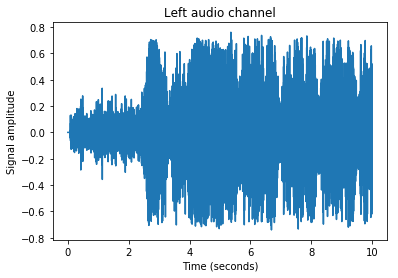

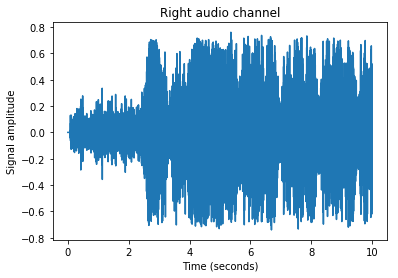

In [11]:
# Plot the time domain signal
data, samplerate = sf.read(audio_filepath)
t_step = 1.0/samplerate
t = np.arange(0, data.shape[0] * t_step, t_step)
plt.plot(t, data[:,0])
plt.title('Left audio channel')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal amplitude')

plt.figure()
plt.plot(t, data[:,1])
plt.title('Right audio channel')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal amplitude')

## Use moviepy to read video and audio frames from mp4 files

In [27]:
from moviepy.editor import *

In [28]:
# Get audio clip
clip = AudioFileClip('video.mp4')
print('# of frames: {}'.format(clip.duration * clip.fps))

# of frams: 1038555.0


In [30]:
# Get several stereo audio frames
import itertools
some_frames = itertools.islice(clip.iter_frames(), 100000, 100020)
for frame in some_frames:
    print(frame)

[ 0.03274536  0.03274536]
[ 0.02920532  0.02920532]
[ 0.0256958  0.0256958]
[ 0.02407837  0.02407837]
[ 0.02151489  0.02151489]
[ 0.01812744  0.01812744]
[ 0.01797485  0.01797485]
[ 0.01669312  0.01669312]
[ 0.00976562  0.00976562]
[ 0.00326538  0.00326538]
[ -6.10351562e-05  -6.10351562e-05]
[-0.00280762 -0.00280762]
[-0.0038147 -0.0038147]
[-0.00585938 -0.00585938]
[-0.01068115 -0.01068115]
[-0.01156616 -0.01156616]
[-0.00915527 -0.00915527]
[-0.00872803 -0.00872803]
[-0.00726318 -0.00726318]
[-0.00518799 -0.00518799]


In [31]:
# Get video clip
clip = VideoFileClip('video.mp4')
print('# of frames: {}'.format(clip.duration * clip.fps))

# of frams: 705.7942057942058


In [32]:
# Get the first video frame
import itertools
some_frames = itertools.islice(clip.iter_frames(), 1)
for frame in some_frames:
    print(frame.shape)
    print(frame)

(720, 1280, 3)
[[[222 229 241]
  [222 229 241]
  [222 229 241]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[222 229 241]
  [222 229 241]
  [222 229 241]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[222 229 241]
  [222 229 241]
  [222 229 241]
  ..., 
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ..., 
 [[ 85  71  57]
  [ 86  72  58]
  [ 89  75  61]
  ..., 
  [ 80  78  74]
  [ 87  85  81]
  [ 90  88  84]]

 [[ 56  42  28]
  [ 58  44  30]
  [ 65  51  37]
  ..., 
  [ 75  73  69]
  [ 86  84  80]
  [ 88  86  82]]

 [[ 47  33  19]
  [ 51  37  23]
  [ 61  47  33]
  ..., 
  [ 69  67  63]
  [ 80  78  74]
  [ 87  85  81]]]


## Sanity check with sox

In [65]:
import sox

sox.file_info.info(audio_filepath)

{'bitrate': 16,
 'channels': 2,
 'duration': 9.999501,
 'encoding': 'FLAC',
 'num_samples': 440978,
 'sample_rate': 44100.0,
 'silent': False}